## Sprint1 Feb/01 
Week4の授業課題の続き利用して進める。
Sprint1からの変更は下の方にある

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [2]:
def gen_range(value_start, value_end, value_step):
    """
    range関数を小数点が扱えるように拡張。value_startから始めてvalue_endに到達するまでvalue_stepを加え続ける。計算を実行する毎にその値を返す。
    ----------------
    Parameter
        value_start:float
        value_end:float
        value_step:float
    ----------------
    ----------------
    Return
    　　value:float value_minにvalue_stepを加えた値
    ----------------
    """
    value = value_start
    while value+value_step < value_end:
     yield value
     value += value_step

In [3]:
def binning_data(data_source, col_name, binned_col_name, num_of_bin=10, option="IQR"):
    """
    指定された列を指定されたbinの数に分割し、bin毎にラベル付けされたデータを元データに追加する
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    binned_col_name : string 
    num_of_bin : int
    
    return
    --------------
    data_source : pandas dataframe
    
    """
    
    if option == "IQR":
        #bin幅の決定のため四分位数を調べる。（外れ値を除く）
        data_info = data_source.describe()
        bin_min = data_info.loc["25%", col_name]
        bin_max = data_info.loc["75%", col_name]
        IQR = bin_max - bin_min
        bin_min = bin_min-IQR*1.5 if bin_min > IQR*1.5 else 0 #これ以下は外れ値とする。(0を最低値とする)
        bin_max += IQR*1.5 #これ以上は外れ値とする
        bin_min = (int)(bin_min)
        bin_max = (int)(bin_max)+1
    elif option == "MINMAX":
        data_info = data_source.describe()
        bin_min = (int)(data_info.loc["min", col_name])
        bin_max = (int)(data_info.loc["max", col_name])+1    
    
    bin_width = (int)((bin_max - bin_min) / num_of_bin)
    bins = [value for value in range(bin_min, bin_max, bin_width)]
    #bin_width = (bin_max - bin_min) / num_of_bin
    #bins = [value for value in gen_range(bin_min, bin_max, bin_width )]
    labels = [i for i in range(0, len(bins)-1)]
    binned_label = pd.cut(data_source[col_name], bins=bins, labels=labels)
    data_source[binned_col_name] = binned_label

    for i in range(0, len(bins)-1):
        print("range label={} : range={:.5f}~{:.5f}".format(i, bins[i], bins[i+1]) )
    
    return data_source

In [4]:
def plot_non_repayment_rate(data_source, col_name, flag_rename_x_label=False):
    """
    X軸を指定された列として未偏差率を棒グラフでプロット
    
    parameter
    --------------
    data_source : Pandas dataframe
    col_name : string 
    flag_rename_x_label : bool
    
    return
    --------------
    None
    """
    
    #ラベル毎に返済率を算出
    non_repayment_rate = data_source.groupby(col_name, as_index=False).mean()
    non_repayment_rate["TARGET"] *= 100
    #print(non_repayment_rate)
    
    #Bar plot
    plt.figure(figsize=(25,10))
    plt.bar(non_repayment_rate.index, non_repayment_rate["TARGET"], color="Blue")
    plt.xlabel(col_name, fontsize=18)
    plt.ylabel("Non-payment rate[%]", fontsize=18)
    plt.title("Non-payment rate")
    plt.tight_layout()
    
    #グラフ上に数値表示
    """
    for x, y in zip(non_repayment_rate.index, non_repayment_rate["TARGET"]):
        plt.text(x, y, str("{:.2f}").format(y), ha='center', va='bottom')
        if flag_rename_x_label == True:
            plt.xticks(non_repayment_rate.index, non_repayment_rate[col_name]) #x軸を実際のデータラベルへ置き換え
    """
    plt.show()

In [5]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def pipeline(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    #学習データ、テストデータに分ける
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
    train_feature = train_data[feature_value].values
    train_target = train_data[target_value].values
    test_feature = test_data[feature_value].values
    test_target = test_data[target_value].values
    print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
    
    #学習データの特徴量を標準化
    if normalization == True:
        scaler = StandardScaler()
        scaler.fit(train_feature)
        train_feature = scaler.transform(train_feature)
        scaler.fit(test_feature)
        test_feature = scaler.transform(test_feature)

    #学習と予測
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
    
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    #rocをplot
    if plot == True:
        plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.show()
    
    return result, fpr, tpr, thresholds

### Kaggle 提出データを作る

In [6]:
import copy
selected_feature_name = ["OCCUPATION_TYPE", 
                         "ORGANIZATION_TYPE",
                         "EXT_SOURCE_1",
                         "EXT_SOURCE_2",
                         "DAYS_EMPLOYED", 
                         "DAYS_REGISTRATION", 
                         "AMT_CREDIT", 
                         "DAYS_BIRTH", 
                         "DEF_60_CNT_SOCIAL_CIRCLE", 
                         "AMT_INCOME_TOTAL", 
                         "CNT_CHILDREN"]
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [7]:
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/week3/session/all/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [8]:
#借り入れ量
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_train, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["BIN_AMT_GOODS_PRICE"])

#経済的負荷
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["CNT_CHILDREN"])
binning_data(pd_application_train, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")

#Nanの数
pd_application_train["NUM_OF_NAN"] = pd_application_train.isnull().sum(axis=1)
binning_data(pd_application_train, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")

#オブジェクト型を数値に置き換え
object_col_name = pd_application_train.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_application_train[object_col_name[i]])
    pd_application_train[object_col_name[i]] = labels    

pd_application_train  = pd_application_train.replace(np.nan, -1)

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range labe

In [9]:
#pd_reducted_train_data = pd_application_train[col_name]

In [10]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

def pipeline(model, data, target_value, feature_value, positive_label, normalization=True, plot=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    #学習データ、テストデータに分ける
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
    train_feature = train_data[feature_value].values
    train_target = train_data[target_value].values
    test_feature = test_data[feature_value].values
    test_target = test_data[target_value].values
    print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
    
    #学習データの特徴量を標準化
    if normalization == True:
        scaler = StandardScaler()
        scaler.fit(train_feature)
        train_feature = scaler.transform(train_feature)
        scaler.fit(test_feature)
        test_feature = scaler.transform(test_feature)

    #学習と予測
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
    
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    #rocをplot
    if plot == True:
        plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.ylim([0.0, 1.0])
        plt.xlim([0.0, 1.0])
        plt.show()
    
    return result, fpr, tpr, thresholds

In [11]:
#test.csvを読む
pd_application_test = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/home_credit/application_test.csv")

#借り入れ量
binning_data(pd_application_test, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_test["BIN_AMT_INCOME_TOTAL"] = pd_application_test["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_test, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_test["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_test["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_test["BIN_AMT_GOODS_PRICE"])

#経済的負荷
binning_data(pd_application_test, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_test["BIN_AMT_INCOME_TOTAL"] = pd_application_test["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_test["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_test["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_test["CNT_CHILDREN"])
binning_data(pd_application_test, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")

#Nanの数
pd_application_test["NUM_OF_NAN"] = pd_application_test.isnull().sum(axis=1)
binning_data(pd_application_test, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")

#オブジェクト型を数値に置き換え
object_col_name = pd_application_test.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_application_test[object_col_name[i]])
    pd_application_test[object_col_name[i]] = labels    

pd_application_test = pd_application_test.replace(np.nan, -1)

range label=0 : range=0.00000~49218.00000
range label=1 : range=49218.00000~98436.00000
range label=2 : range=98436.00000~147654.00000
range label=3 : range=147654.00000~196872.00000
range label=4 : range=196872.00000~246090.00000
range label=5 : range=246090.00000~295308.00000
range label=6 : range=295308.00000~344526.00000
range label=7 : range=344526.00000~393744.00000
range label=0 : range=0.00000~154687.00000
range label=1 : range=154687.00000~309374.00000
range label=2 : range=309374.00000~464061.00000
range label=3 : range=464061.00000~618748.00000
range label=4 : range=618748.00000~773435.00000
range label=5 : range=773435.00000~928122.00000
range label=6 : range=928122.00000~1082809.00000
range label=7 : range=1082809.00000~1237496.00000
range label=0 : range=0.00000~49218.00000
range label=1 : range=49218.00000~98436.00000
range label=2 : range=98436.00000~147654.00000
range label=3 : range=147654.00000~196872.00000
range label=4 : range=196872.00000~246090.00000
range label=

元データ数：307511　学習データ数：230633　検証データ数：76878


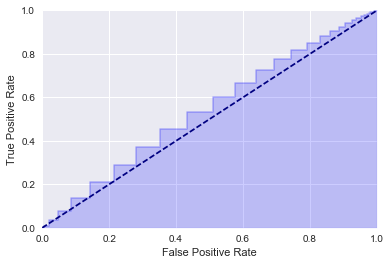

In [12]:
#test data作成
pd_test_data = pd_application_test[selected_feature_name]

#Sample_submissionを読む
pd_submission = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/home_credit/sample_submission.csv")

#モデルを使って予測
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
result, fpr, tpr, thresholds = pipeline(clf, pd_application_train, "TARGET", selected_feature_name, 1, False)

In [13]:
#test dataに対して予測
result_testdata = clf.predict_proba(pd_test_data)

#結果をSample_submissionデータフレームへ
print(result_testdata[:,1])

#print( pd_submission.head() )
pd_submission["TARGET"] = result_testdata[:,1]

#Csvで保存
pd_submission.to_csv("/Users/naoki/Desktop/DIC/Sprint/Sprint1/1st_submission.csv", index=False)

[0.82 0.89 0.89 ... 0.94 0.9  0.88]


# ここからSprint1

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [15]:
#Trainデータ読み込み
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/week3/session/all/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [16]:
#データ下処理

#借り入れ量
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_train, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["BIN_AMT_GOODS_PRICE"])

#経済的負荷
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["CNT_CHILDREN"])
binning_data(pd_application_train, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")

#Nanの数
pd_application_train["NUM_OF_NAN"] = pd_application_train.isnull().sum(axis=1)
binning_data(pd_application_train, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")

#オブジェクト型を数値に置き換え
object_col_name = pd_application_train.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_application_train[object_col_name[i]])
    pd_application_train[object_col_name[i]] = labels    

pd_application_train = pd_application_train.replace(np.nan, -1)

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range labe

#### 【問題1】クロスバリデーション
事前学習期間は検証用データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。
具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。

元データ数：246008　学習データ数：184506　検証データ数：61502


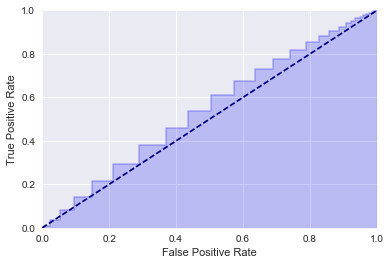

AUC=0.54618
元データ数：246009　学習データ数：184506　検証データ数：61503


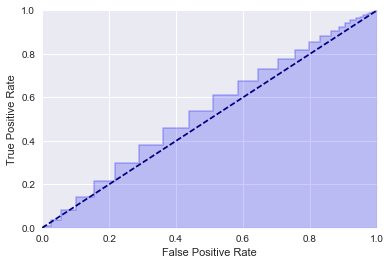

AUC=0.56145
元データ数：246009　学習データ数：184506　検証データ数：61503


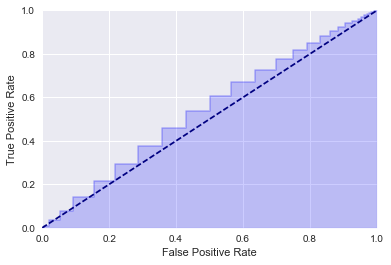

AUC=0.56624
元データ数：246009　学習データ数：184506　検証データ数：61503


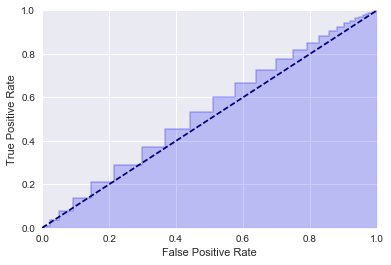

AUC=0.57566
元データ数：246009　学習データ数：184506　検証データ数：61503


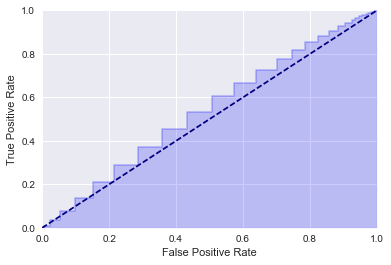

AUC=0.57947


In [17]:
#Kfold CV用データを作成
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in skf.split(
    pd_application_train[selected_feature_name].values, 
    pd_application_train["TARGET"].values):
    
    #print("TRAIN:", train_index)
    #print("TEST:", test_index)
    cv_train = pd_application_train.iloc[train_index]
    cv_test = pd_application_train.iloc[test_index]
    
    result, fpr, tpr, thresholds = pipeline(clf, cv_train, "TARGET", selected_feature_name, 1, False)
    #print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))
    
    result = clf.predict_proba(cv_test[selected_feature_name].values)
    fpr, tpr, thresholds = metrics.roc_curve(cv_test["TARGET"].values, result[:,1], pos_label=1)
    print("AUC={:.5f}".format(metrics.auc(fpr, tpr)))

In [18]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

def pipeline_w_cv(
                   model, data, target_value, feature_value, positive_label, 
                   normalization=True, plot=True, 
                   cv_split=5, cv_random_state=None, cv_shuffle=True):
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    auc_total = 0
    scaler = StandardScaler()
    skf = StratifiedKFold(n_splits=cv_split, random_state=cv_random_state, shuffle=cv_shuffle)
    for train_index, test_index in skf.split(
        data[feature_value].values, 
        data[target_value].values):
        
        cv_train = data.iloc[train_index]
        cv_test = data.iloc[test_index]
        
        #学習データ、テストデータに分ける
        train_feature = cv_train[feature_value].values
        train_target = cv_train[target_value].values
        test_feature = cv_test[feature_value].values
        test_target = cv_test[target_value].values
        
        #学習データの特徴量を標準化
        if normalization == True:
            scaler.fit(train_feature)
            train_feature = scaler.transform(train_feature)
            scaler.fit(test_feature)
            test_feature = scaler.transform(test_feature)
            
        #学習と予測
        model.fit(train_feature, train_target)
        result = model.predict_proba(test_feature)
        
        #rocを計算
        fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
        auc = metrics.auc(fpr, tpr)
        auc_total += auc
        print("AUC={:.5f}".format(auc))
        
        #rocをplot
        if plot == True:
            plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
            plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
            plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.ylim([0.0, 1.0])
            plt.xlim([0.0, 1.0])
            plt.show()
    
    print("Ave AUC : {}".format(auc_total/cv_split))
    
    return

In [19]:
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)
pipeline_w_cv(clf, pd_application_train, "TARGET", selected_feature_name, 1, True, False, 2, False)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.55519


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.54321
Ave AUC : 0.549197380848287


#### 【問題2】グリッドサーチ
これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。
グリッドサーチをパイプラインの中に組み込みましょう。

In [20]:
#Report top scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [21]:
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(n_estimators=100, max_depth=120, random_state=40)

#Random forestパラメーター
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators" : [30, 50, 100],
              "random_state" : [10, 50, 100]
             }

#時間がかかるのでtrain dataを30000件に絞る
tmp = pd_application_train.sample(n=30000)
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2)
grid_search.fit(tmp[selected_feature_name].values, tmp["TARGET"].values)
report(grid_search.cv_results_)

KeyboardInterrupt: 

In [ ]:
print("Best param ",grid_search.best_params_)

#### Grid searchの結果を反映＆再評価

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.55186


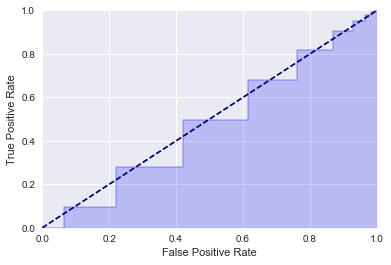

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.54090


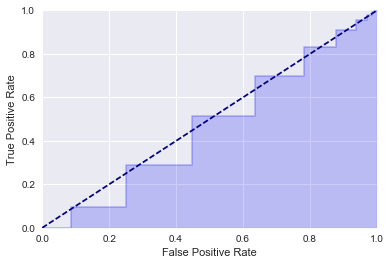

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.54139


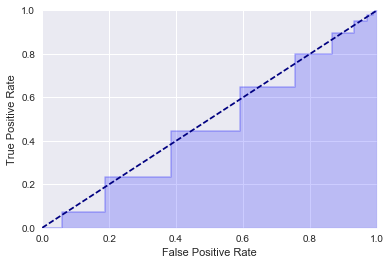

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.54320


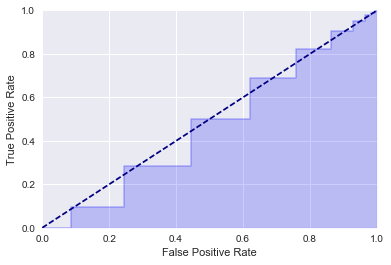

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.54582


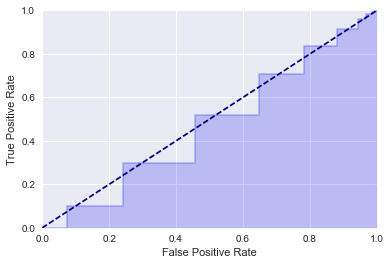

Ave AUC : 0.5446345213622692


In [22]:
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")
pipeline_w_cv(clf, pd_application_train, "TARGET", selected_feature_name, 1, 
              True, True, 
              5, None, True)

In [23]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [24]:
def plot_roc(fpr, tpr):
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.show()

In [25]:
def train_model(model, train_feature, train_target, test_feature, test_target, positive_label):
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
        
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    auc = metrics.auc(fpr, tpr)
    print("AUC={:.5f}".format(auc))
    
    return result, fpr, tpr, auc

In [26]:
def pipeline_w_cv_grid(
            model, data, target_value, feature_value, positive_label, 
            normalization_on=True, roc_plot_on=True, 
            cv_on=True, cv_split=5, cv_random_state=None, cv_shuffle=True,
            grid_search_on=True, param_grid={}):
    
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    normalization :フラグ True=正規分布で規格化　False=規格化しない
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    auc = 0
    if cv_on == True:
        print("Run cross validation")
        scaler = StandardScaler()
        skf = StratifiedKFold(n_splits=cv_split, random_state=cv_random_state, shuffle=cv_shuffle)
        for train_index, test_index in skf.split(
            data[feature_value].values, 
            data[target_value].values):
            
            cv_train = data.iloc[train_index]
            cv_test = data.iloc[test_index]
        
            #学習データ、テストデータに分ける
            train_feature = cv_train[feature_value].values
            train_target = cv_train[target_value].values
            test_feature = cv_test[feature_value].values
            test_target = cv_test[target_value].values
        
            #学習データの特徴量を標準化
            if normalization_on == True:
                print("Normalize feature data")
                scaler.fit(train_feature)
                train_feature = scaler.transform(train_feature)
                scaler.fit(test_feature)
                test_feature = scaler.transform(test_feature)
            
            #学習と予測
            result, fpr, tpr, auc_from_cv = train_model(model, train_feature, train_target, test_feature, test_target, positive_label)
            print("Auc_from_cv=", auc_from_cv )
            auc += auc_from_cv/cv_split
            #rocをplot
            if roc_plot_on == True:
                plot_roc(fpr, tpr)
                
    else:
        #学習データ、テストデータに分ける
        print("Split data train & test")
        train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
        train_feature = train_data[feature_value].values
        train_target = train_data[target_value].values
        test_feature = test_data[feature_value].values
        test_target = test_data[target_value].values
        print("元データ数：{}　学習データ数：{}　検証データ数：{}".format(len(data), len(train_data), len(test_data)))
           
        if normalization_on == True:
            print("Normalize feature data")
            scaler.fit(train_feature)
            train_feature = scaler.transform(train_feature)
            scaler.fit(test_feature)
            test_feature = scaler.transform(test_feature)
        
        #学習と予測
        result, fpr, tpr, auc = train_model(train_feature, train_target, test_feature, test_target, positive_label)
            
        #rocをplot
        if roc_plot_on == True:
            plot_roc(fpr, tpr)
            
    print("AUC : {}".format(auc))
    
    if grid_search_on == True:
        #時間がかかるのでtrain dataを30000件に絞る
        tmp = pd_application_train.sample(n=30000)
        grid_search = GridSearchCV(clf, param_grid=param_grid, cv=2)
        grid_search.fit(tmp[selected_feature_name].values, tmp["TARGET"].values)
        model.set_params(**grid_search.best_params_)
        print("Set best params ",grid_search.best_params_)
        
    return result, fpr, tpr, auc, grid_search.best_params_

In [28]:
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")

#Random forestパラメーター
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
             }

#Run pipeline
pipeline_w_cv_grid(
              clf, pd_application_train, "TARGET", selected_feature_name, 1, 
              True, True, 
              True, 2, None, True,
              True, param_grid)

Run cross validation
Normalize feature data


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


KeyboardInterrupt: 

Pipelineを作り直した。
CV, Grid searchを含む

In [29]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [30]:
def plot_roc(fpr, tpr):
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.show()

In [31]:
def train_model(model, train_feature, train_target, test_feature, test_target, positive_label):
    model.fit(train_feature, train_target)
    result = model.predict_proba(test_feature)
        
    #rocを計算
    fpr, tpr, thresholds = metrics.roc_curve(test_target, result[:,1], pos_label=positive_label)
    auc = metrics.auc(fpr, tpr)
    print("AUC={:.5f}".format(auc))
    
    return result, fpr, tpr, auc

In [32]:
def pipeline2(model, data, target_value, feature_value, pos_label=1, params={}, params_grid={}):
    
    """
    Parameter
    ---------------
    model : 利用するライブラリのオブジェクト
    target_value :目的変数名
    feature_value :　説明変数名
    pos_label : 目的変数 Positive label指定
    Params :  この関数のパラメーター達
    params_grid : GridSearchのパラメータ達
    
    Return
    ---------------
    fpr, tpr, thresholds
    """
    
    auc_total = 0
    if params.get("cv_on") == True:
        print("Run cross validation")
        train_x = [0 for _ in range(params.get("cv_split"))]
        train_y = [0 for _ in range(params.get("cv_split"))]
        test_x = [0 for _ in range(params.get("cv_split"))]
        test_y = [0 for _ in range(params.get("cv_split"))]    
        
        scaler = StandardScaler()
        skf = StratifiedKFold(
                            n_splits=params.get("cv_split"), 
                            random_state=params.get("cv_random_state"), 
                            shuffle=params.get("cv_shuffle"))
        
        i = 0
        for train_index, test_index in skf.split(
            data[feature_value].values, 
            data[target_value].values):
            
            cv_train = data.iloc[train_index]
            cv_test = data.iloc[test_index]
        
            #学習データ、テストデータに分ける
            train_x[i] = cv_train[feature_value].values
            train_y[i] = cv_train[target_value].values
            test_x[i] = cv_test[feature_value].values
            test_y[i] = cv_test[target_value].values
            i +=1
            
    else:
        #学習データ、テストデータに分ける  
        print("Split data train & test")
        train_x = [0]
        train_y = [0]
        test_x = [0]
        test_y = [0]          
        
        train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
        train_x[0] = train_data[feature_value].values
        train_y[0] = train_data[target_value].values
        test_x[0] = test_data[feature_value].values
        test_y[0] = test_data[target_value].values
        print("元データ数：{}　学習データ数：{}　検証データ数：{}"
                                  .format(len(data), len(train_data), len(test_data)))
                 
    for num in range(0, len(train_x)):
        train_feature = train_x[num]
        train_target = train_y[num]
        test_feature = test_x[num]
        test_target = test_y[num]
        
        if params.get("normalization_on") == True:
            print("Normalize feature data")
            scaler.fit(train_feature)
            train_feature = scaler.transform(train_feature)
            scaler.fit(test_feature)
            test_feature = scaler.transform(test_feature)

            #学習と予測
            result, fpr, tpr, auc = train_model(
                                        model, 
                                        train_feature, train_target,
                                        test_feature, test_target,
                                        pos_label)
            print("Auc : ", auc)
            auc_total += auc

            #rocをplot
            if params.get("roc_plot_on") == True:
                plot_roc(fpr, tpr)
                
    if params.get("cv_on") == True:
        print("AUC for cv (Ave of {} cv split) : {}".format(i, (auc_total / i)))

    if params.get("grid_search_on") == True:
        #時間がかかるのでtrain dataを30000件に絞る
        tmp = data.sample(n=30000)
        grid_search = GridSearchCV(
                    clf,
                    param_grid=params_grid.get("hyper_param"), 
                    cv=params_grid.get("grid_search_param",{}).get("grid_search_cv"))
            
        grid_search.fit(tmp[feature_value].values, tmp[target_value].values)
        model.set_params(**grid_search.best_params_)
        print("Set best params ",grid_search.best_params_)

    return result, fpr, tpr, auc

Run cross validation
Normalize feature data


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.54162
Auc :  0.5416208875923118


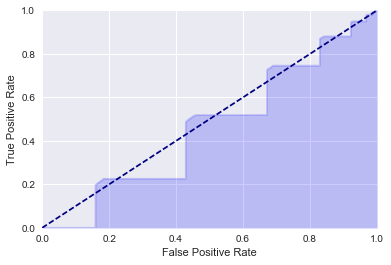

Normalize feature data


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


AUC=0.54755
Auc :  0.5475516724287308


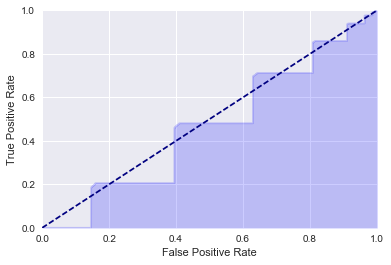

AUC for cv (Ave of 2 cv split) : 0.5445862800105212


(array([[0.35, 0.65],
        [0.3 , 0.7 ],
        [0.4 , 0.6 ],
        ...,
        [0.1 , 0.9 ],
        [0.05, 0.95],
        [0.3 , 0.7 ]]),
 array([0.        , 0.14614889, 0.14639059, ..., 0.99991943, 0.99991943,
        1.        ]),
 array([0.        , 0.18515243, 0.1856406 , ..., 0.99997878, 0.99998585,
        1.        ]),
 0.5475516724287308)

In [33]:
clf = RandomForestClassifier(
    n_estimators=20, max_depth=50, random_state=100, criterion="entropy", bootstrap="True")

#pipelineパラメーター
params_ext = {
         "normalization_on": True,
          "roc_plot_on": True,
          "cv_on": True,
          "cv_split": 2,
          "cv_random_state" : None,
          "cv_shuffle" : True,
          "grid_search_on" : False,
        }
#Grid search
param_grid = {
            "hyper_param":{
                "max_depth": [50, 120],
                "max_features": [3, 10],
                "min_samples_split": [3, 10],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"],
                "n_estimators" : [30, 50, 100],
                "random_state" : [10, 50, 100]
            },
            "grid_search_param":{
                    "grid_search_cv":2
            }
        }

#Run pipeline
pipeline2(
    clf, pd_application_train, "TARGET", selected_feature_name, 1, 
    params=params_ext, 
    params_grid=param_grid)

#### 【問題3】Kernelからの調査
KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。

1. Automated feature creation
https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics
DPF

2. Hyper param tuning
https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search
GritSearch, RandomSearch

3. LightGBM
よく使われている。

4. Feature selection
https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
"Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set"
==> 選んだ30個のデータに対しこれを行う。(0.9 以上はどちらか一方を使う)

5. Dimentionaly reduction
・PCA, ICA, Manifold learning

6. Polynomial Features(sklearn)
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
==>特徴量を増やす (多項式から算出　例えばdegree=2の場合　[1, a, b, a^2, ab, b^2])

7. 欠損値、外れ値の処理
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction 
この人を参考にする。選んだ30個の特徴量の外れ値を確認。外れ値のindexは削除または平均に置き換える。


In [34]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'BIN_AMT_GOODS_PRICE',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'BIN_NUM_OF_NAN',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'BIN_AMT_INCOME_TOTAL',
                         'BIN_DEG_IRESP_INCOME_GOODS_PRICE',
                         'DAYS_ID_PUBLISH',
                         'DEG_IRESP_INCOME_GOODS_PRICE',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [35]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'DAYS_ID_PUBLISH',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [36]:
pd_application_train = pd.read_csv("/Users/naoki/Desktop/DIC/kaggle/home_credit/application_train.csv")
pd.options.display.max_columns = len(pd_application_train.columns)

In [37]:
#借り入れ量
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
binning_data(pd_application_train, "AMT_GOODS_PRICE", "BIN_AMT_GOODS_PRICE", 8)
pd_application_train["DEG_IRESP_INCOME_GOODS_PRICE"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["BIN_AMT_GOODS_PRICE"])

#経済的負荷
binning_data(pd_application_train, "AMT_INCOME_TOTAL", "BIN_AMT_INCOME_TOTAL", 8)
pd_application_train["BIN_AMT_INCOME_TOTAL"] = pd_application_train["BIN_AMT_INCOME_TOTAL"].replace(np.nan, 10)
pd_application_train["DEG_SEVERITY_INCOME_CNT_CHILDREN"] = (10 - pd_application_train["BIN_AMT_INCOME_TOTAL"])*(1 + pd_application_train["CNT_CHILDREN"])
binning_data(pd_application_train, "DEG_IRESP_INCOME_GOODS_PRICE", "BIN_DEG_IRESP_INCOME_GOODS_PRICE", 8, "MINMAX")

#Nanの数
pd_application_train["NUM_OF_NAN"] = pd_application_train.isnull().sum(axis=1)
binning_data(pd_application_train, "NUM_OF_NAN", "BIN_NUM_OF_NAN", 10, "MINMAX")

#オブジェクト型を数値に置き換え
object_col_name = pd_application_train.columns.values
for i in range(0,len(object_col_name)):
    labels, uniques = pd.factorize(pd_application_train[object_col_name[i]])
    pd_application_train[object_col_name[i]] = labels    

pd_application_train = pd_application_train.replace(np.nan, -1)

range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range label=5 : range=210935.00000~253122.00000
range label=6 : range=253122.00000~295309.00000
range label=7 : range=295309.00000~337496.00000
range label=0 : range=0.00000~167625.00000
range label=1 : range=167625.00000~335250.00000
range label=2 : range=335250.00000~502875.00000
range label=3 : range=502875.00000~670500.00000
range label=4 : range=670500.00000~838125.00000
range label=5 : range=838125.00000~1005750.00000
range label=6 : range=1005750.00000~1173375.00000
range label=7 : range=1173375.00000~1341000.00000
range label=0 : range=0.00000~42187.00000
range label=1 : range=42187.00000~84374.00000
range label=2 : range=84374.00000~126561.00000
range label=3 : range=126561.00000~168748.00000
range label=4 : range=168748.00000~210935.00000
range labe

In [38]:
pd_reducted_train_data = pd_application_train[col_name]
pd_reducted_train_data.describe()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,23827.150414,46901.170583,5922.236118,2538.720384,27.696609,556.241416,7913.592219,1.060021,34.912172,0.273772,2663.782219,0.417312,2.96231,0.179555,9.546556,0.056720,0.396366,0.098055,1.079366,-0.466413,1.678688,2530.838006,0.349649,-0.488070,2.280504,0.919271
std,34742.540153,32821.881130,3765.009888,2534.048092,19.595369,829.327591,4763.152782,0.327226,149.230919,0.829839,2843.531578,0.723469,2.16452,0.383817,10.846045,0.231307,0.724237,0.735406,0.378965,0.513823,2.206728,1587.148893,0.612447,0.535714,3.830350,0.272419
min,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,-1.000000,18389.000000,2713.000000,395.000000,12.000000,59.000000,3789.000000,1.000000,4.000000,0.000000,448.000000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,1158.000000,0.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,42363.000000,5600.000000,1905.000000,22.000000,189.000000,7740.000000,1.000000,12.000000,0.000000,1607.000000,0.000000,3.00000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2396.000000,0.000000,-1.000000,1.000000,1.000000
75%,45141.500000,72025.000000,8835.000000,3920.000000,40.000000,689.000000,11888.000000,1.000000,21.000000,0.000000,4044.000000,1.000000,5.00000,0.000000,12.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,3840.000000,1.000000,0.000000,5.000000,1.000000
max,114583.000000,119830.000000,15687.000000,12573.000000,80.000000,5602.000000,17459.000000,8.000000,2547.000000,5.000000,13671.000000,14.000000,6.00000,1.000000,57.000000,1.000000,2.000000,10.000000,9.000000,1.000000,24.000000,6167.000000,4.000000,2.000000,17.000000,1.000000


#### 1. Polynomial Features

In [39]:
# Make a new dataframe for polynomial features
poly_features = pd_application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
#poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(['TARGET'], axis=1)

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
#poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [40]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
#poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [41]:
poly_transformer.get_feature_names(input_features = 
                                   ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

効果の確認

In [42]:
from sklearn.preprocessing import MinMaxScaler
#元データに新しい特徴量を追加
# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))
poly_features = scaler.fit_transform(poly_features)
#poly_features.shape

#poly featureをpandas dataframeへ
poly_col_name = poly_transformer.get_feature_names(input_features = 
                                   ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

pd_poly_features = pd.DataFrame(poly_features, columns=poly_col_name)
pd_poly_features.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_3^2,EXT_SOURCE_3 DAYS_BIRTH,DAYS_BIRTH^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1^2 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_1 DAYS_BIRTH^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3
0,0.0,0.000009,0.000008,0.001229,0.000000,0.000000e+00,0.000009,0.001307,0.000009,0.000000e+00,0.001264,0.000008,0.000000,0.001281,0.000000e+00,6.647211e-16,0.000008,0.001332,0.000000e+00,0.000009,0.001346,0.000009,0.000009,0.001465,0.000009,5.811702e-16,0.00129,0.000000e+00,0.000006,0.00142,0.000008,1.860923e-09,0.000000e+00,0.001296,0.000000e+00
1,0.0,0.000017,0.000017,0.000000,0.000057,7.616573e-11,0.000009,0.001307,0.000009,6.964162e-11,0.001264,0.000008,0.000002,0.001281,3.280660e-09,1.329442e-15,0.000008,0.001332,4.415568e-15,0.000009,0.001346,0.000009,0.000009,0.001465,0.000009,1.162340e-15,0.00129,4.023087e-15,0.000006,0.00142,0.000008,0.000000e+00,9.327297e-11,0.001296,1.879065e-13
2,0.0,0.000000,0.000025,0.002457,0.000115,7.616573e-11,0.000009,0.001307,0.000009,2.785665e-10,0.001264,0.000008,0.000002,0.001282,1.312264e-08,0.000000e+00,0.000008,0.001332,8.831136e-15,0.000009,0.001346,0.000009,0.000009,0.001465,0.000009,5.230532e-15,0.00129,3.218470e-14,0.000006,0.00142,0.000008,3.721846e-09,1.865459e-10,0.001296,1.503252e-12
3,0.0,0.000000,0.000033,0.000000,0.000172,7.616573e-11,0.000009,0.001307,0.000009,6.267746e-10,0.001264,0.000008,0.000002,0.001281,2.952594e-08,0.000000e+00,0.000008,0.001332,1.324670e-14,0.000009,0.001346,0.000009,0.000009,0.001465,0.000009,1.627277e-14,0.00129,1.086234e-13,0.000006,0.00142,0.000008,0.000000e+00,2.798189e-10,0.001296,5.073477e-12
4,0.0,0.000000,0.000042,0.000000,0.000229,7.616573e-11,0.000009,0.001307,0.000009,1.114266e-09,0.001264,0.000008,0.000002,0.001281,5.249057e-08,0.000000e+00,0.000008,0.001332,1.766227e-14,0.000009,0.001346,0.000009,0.000009,0.001465,0.000009,3.777606e-14,0.00129,2.574776e-13,0.000006,0.00142,0.000008,0.000000e+00,3.730919e-10,0.001296,1.202602e-11


In [43]:
train_data_w_poly = pd.concat([pd_application_train, pd_poly_features], axis=1)

In [44]:
#selected_feature_name_w_poly = copy.deepcopy(selected_feature_name)
#selected_feature_name_w_poly.append(poly_col_name)
selected_feature_name_w_poly = selected_feature_name + poly_col_name
print(selected_feature_name_w_poly)

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE', 'AMT_CREDIT', 'DAYS_BIRTH', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE', 'AMT_ANNUITY', 'CNT_CHILDREN', 'WEEKDAY_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY', 'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_ID_PUBLISH', 'NAME_EDUCATION_TYPE', 'HOUSETYPE_MODE', 'OCCUPATION_TYPE', '1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3', 'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2', 'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2', 'EXT_SOURCE_1^3', 'EXT_SOURCE_1^2 EXT_SOURCE_2', 'EXT_SOURCE_1^2 EXT_SOURCE_3', 'EXT_SOURCE_1^2 DAYS_BIRTH', 'EXT_SOURCE_1 EXT_SOURCE_2^2', 'EXT_SOURCE_1 

Run cross validation
Normalize feature data
AUC=0.57747
Auc :  0.5774709374764104


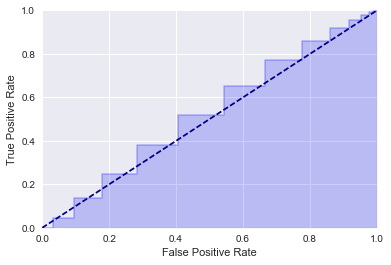

Normalize feature data
AUC=0.57132
Auc :  0.5713234696753499


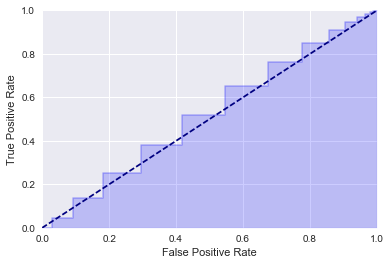

Normalize feature data
AUC=0.57245
Auc :  0.5724462948726055


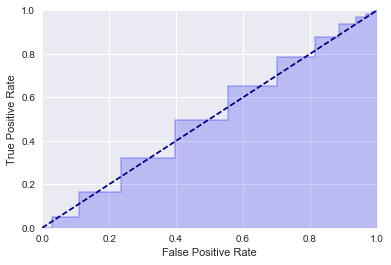

Normalize feature data
AUC=0.56734
Auc :  0.5673363490486432


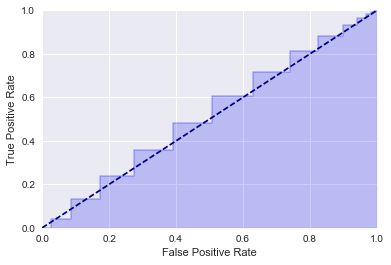

Normalize feature data
AUC=0.55646
Auc :  0.5564606240179123


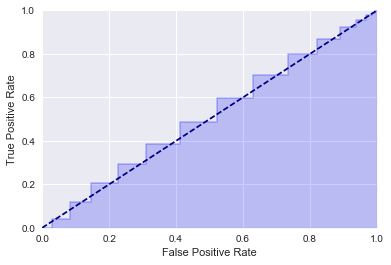

AUC for cv (Ave of 5 cv split) : 0.5690075350181842


(array([[0.43333333, 0.56666667],
        [0.5       , 0.5       ],
        [0.23333333, 0.76666667],
        ...,
        [0.13333333, 0.86666667],
        [0.23333333, 0.76666667],
        [0.26666667, 0.73333333]]),
 array([0.        , 0.02779456, 0.08378651, 0.14602216, 0.22557905,
        0.31117825, 0.41047331, 0.52104733, 0.63001007, 0.73333333,
        0.8203424 , 0.89063444, 0.93716012, 0.9673716 , 0.98509567,
        0.99415911, 0.99778449, 0.99859013, 0.99919436, 0.99919436,
        0.99959718, 0.99979859, 0.99979859, 1.        ]),
 array([0.        , 0.04253851, 0.11779896, 0.20434406, 0.29322391,
        0.38489839, 0.48828201, 0.59821002, 0.70438828, 0.79754851,
        0.86996126, 0.92129048, 0.95512673, 0.97644021, 0.98876842,
        0.99504749, 0.99784212, 0.999151  , 0.99975237, 0.99994694,
        0.99996462, 0.99998231, 1.        , 1.        ]),
 0.5564606240179123)

In [45]:
#Pipelineを回す
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")

#pipelineパラメーター
POSITIVE_LABEL = 1

params_ext = {
         "normalization_on": True,
          "roc_plot_on": True,
          "cv_on": True,
          "cv_split": 5,
          "cv_random_state" : None,
          "cv_shuffle" : True,
          "grid_search_on" : False,
        }
#Grid search
param_grid = {
            "hyper_param":{
                "max_depth": [50, 120],
                "max_features": [3, 10],
                "min_samples_split": [3, 10],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"],
                "n_estimators" : [30, 50, 100],
                "random_state" : [10, 50, 100]
            },
            "grid_search_param":{
                    "grid_search_cv":2
            }
        }

#Run pipeline
pipeline2(
    clf, train_data_w_poly, "TARGET", selected_feature_name_w_poly, POSITIVE_LABEL, 
    params=params_ext, 
    params_grid=param_grid)

#### 2. 外れ値の処理
これまでIQR x 1.5のデータ範囲を決めたため、外れ値は最大binに割り振られている。
それ以外のデータについては外れ値の確認が必要

In [46]:
import copy
selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'REGION_POPULATION_RELATIVE',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'DEF_60_CNT_SOCIAL_CIRCLE',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'WEEKDAY_APPR_PROCESS_START',
                         'LIVE_CITY_NOT_WORK_CITY',
                         'ORGANIZATION_TYPE',
                         'FLAG_EMAIL',
                         'REGION_RATING_CLIENT_W_CITY',
                         'AMT_REQ_CREDIT_BUREAU_QRT',
                         'DEF_30_CNT_SOCIAL_CIRCLE',
                         'EMERGENCYSTATE_MODE',
                         'AMT_REQ_CREDIT_BUREAU_YEAR',
                         'DAYS_ID_PUBLISH',
                         'NAME_EDUCATION_TYPE',
                         'HOUSETYPE_MODE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [47]:
def plot_hist(data, col_name):
    # Set the style of plots
    plt.style.use('fivethirtyeight')
    # Plot the distribution of ages in years
    plt.hist(data[col_name], edgecolor = 'k', bins = 25)
    plt.title(col_name); plt.xlabel("X"); plt.ylabel('Count'); 
    plt.show()

In [48]:
pd_reducted_train_data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,1,1
2,-1,2,2,2,2,2,2,1,2,0,2,0,1,0,2,0,0,0,1,-1,1,2,0,-1,0,1
3,-1,3,3,3,3,3,3,1,3,0,3,0,0,0,0,0,0,-1,1,-1,-1,3,0,-1,0,1
4,-1,4,4,4,4,4,4,1,4,0,4,0,2,1,3,0,0,0,1,-1,1,4,0,-1,1,1


In [49]:
object_data = pd_reducted_train_data.select_dtypes(['object'])
num_data = pd_reducted_train_data.drop(object_data.columns.values, axis=1)

In [50]:
num_data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,1,1
2,-1,2,2,2,2,2,2,1,2,0,2,0,1,0,2,0,0,0,1,-1,1,2,0,-1,0,1
3,-1,3,3,3,3,3,3,1,3,0,3,0,0,0,0,0,0,-1,1,-1,-1,3,0,-1,0,1
4,-1,4,4,4,4,4,4,1,4,0,4,0,2,1,3,0,0,0,1,-1,1,4,0,-1,1,1


In [51]:
num_data = np.abs(num_data)
num_data.head()

,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,AMT_CREDIT,DAYS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,WEEKDAY_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_EMAIL,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_QRT,DEF_30_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_ID_PUBLISH,NAME_EDUCATION_TYPE,HOUSETYPE_MODE,OCCUPATION_TYPE,TARGET
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,1,1
2,1,2,2,2,2,2,2,1,2,0,2,0,1,0,2,0,0,0,1,1,1,2,0,1,0,1
3,1,3,3,3,3,3,3,1,3,0,3,0,0,0,0,0,0,1,1,1,1,3,0,1,0,1
4,1,4,4,4,4,4,4,1,4,0,4,0,2,1,3,0,0,0,1,1,1,4,0,1,1,1


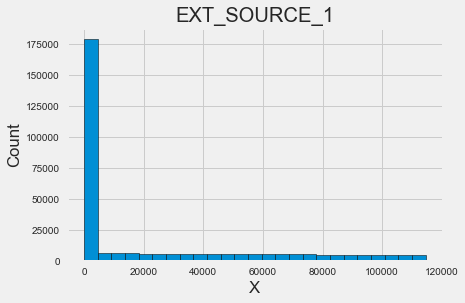

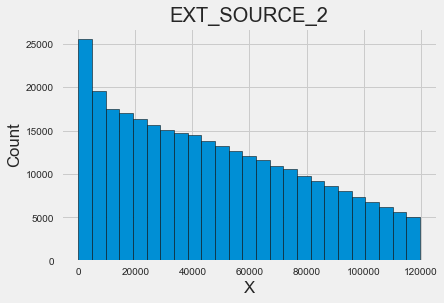

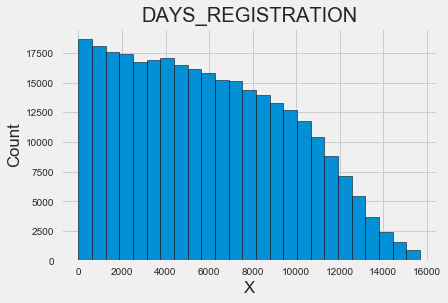

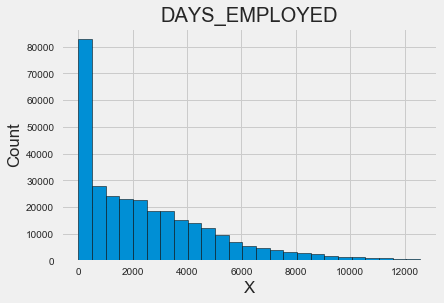

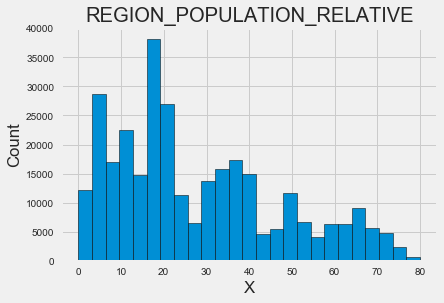

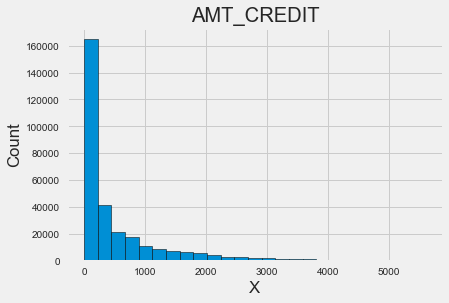

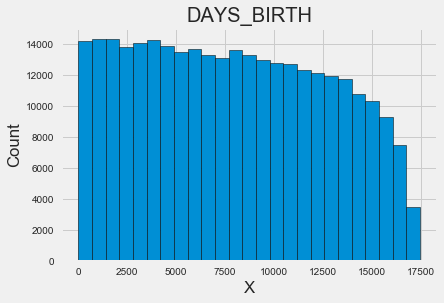

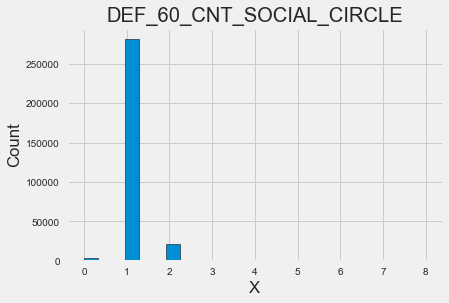

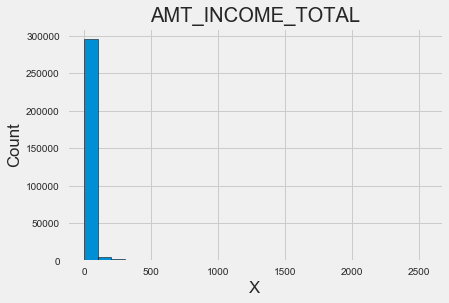

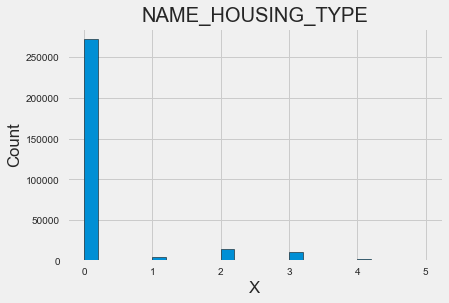

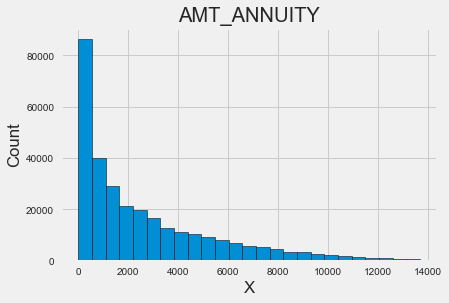

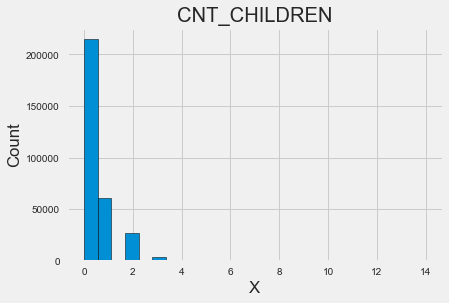

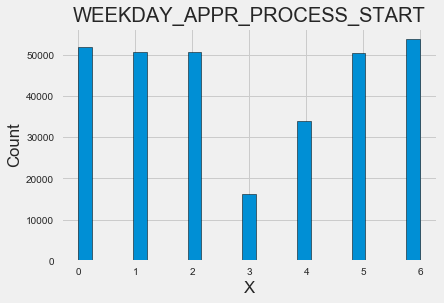

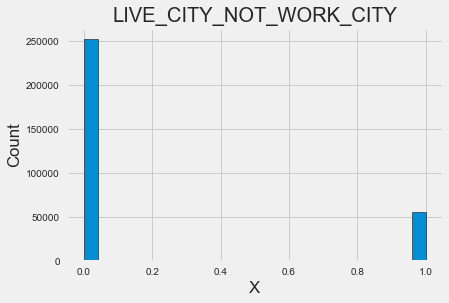

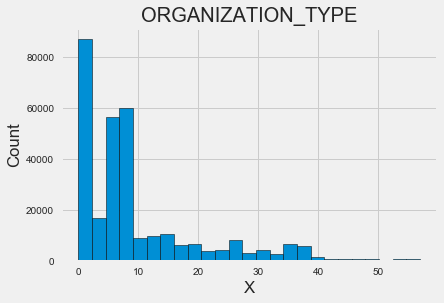

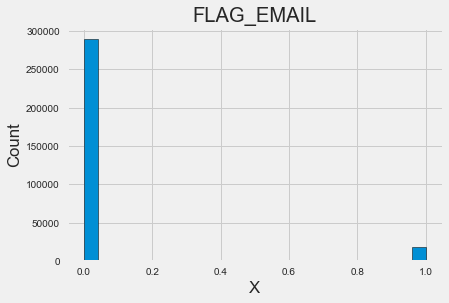

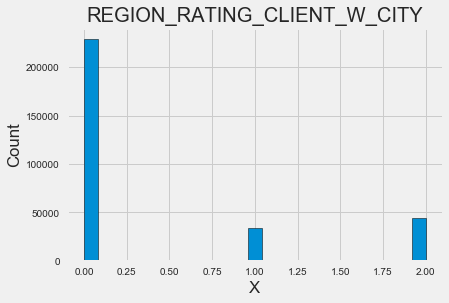

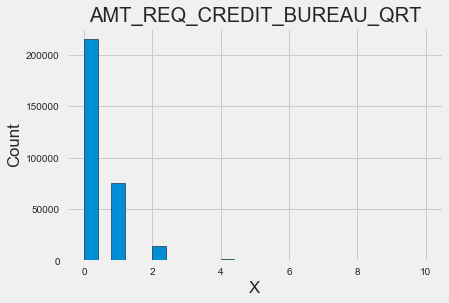

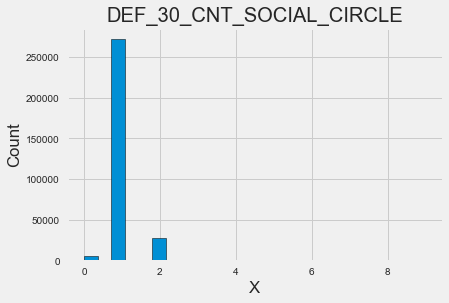

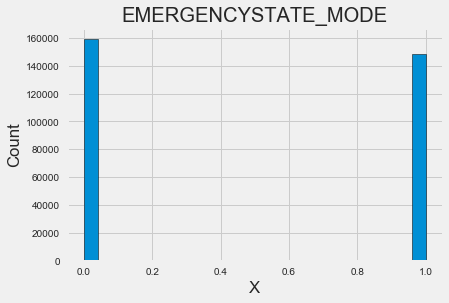

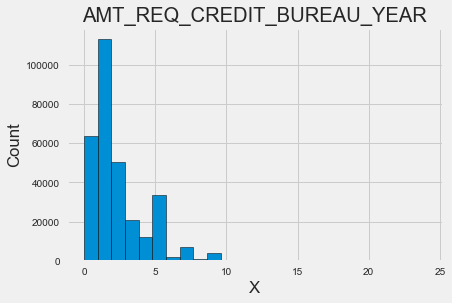

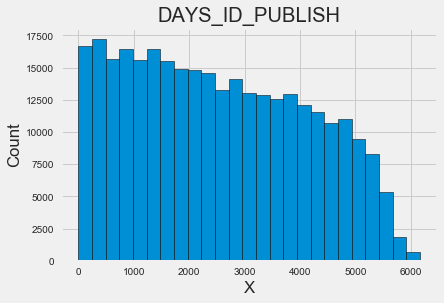

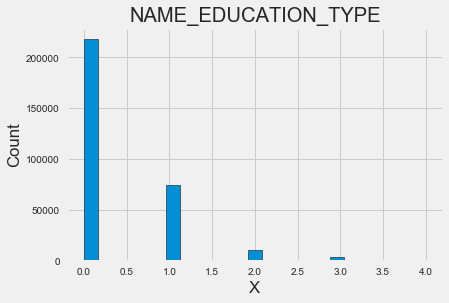

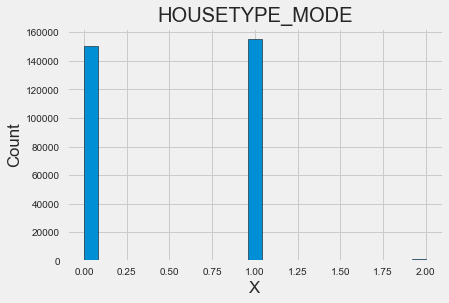

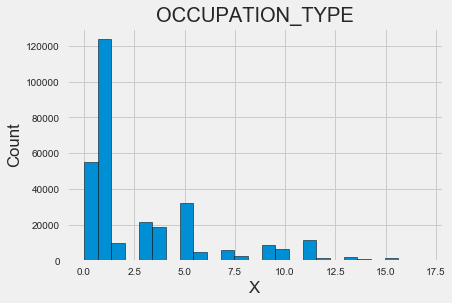

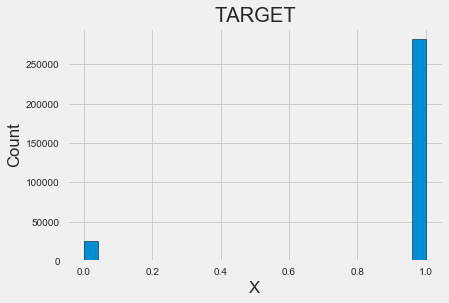

In [52]:
col_name = num_data.columns.values
plot_data = num_data[col_name]
#num_data = num_data.replace(np.nan, -9999)
for i in range(0, len(col_name)):
    plot_hist(plot_data, col_name[i])
#plot_data.dropna(axis = 0, how = 'any')
#plot_data.shape

大きな外れ値はなさそうだ

#### 3. 相関関係の確認とFeature reduction

In [53]:
import seaborn as sb

In [54]:
print(len(col_name))

26


/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/naoki/.pyenv/versions/anaconda3-4.3

[[ 1.00000000e+00  1.55538234e-01 -2.01432360e-02  5.67984082e-02
  -4.90196825e-03  2.45845176e-02  9.30166431e-03  4.10981149e-04
   1.07310055e-02  2.30598911e-02  2.68438075e-02  8.47314281e-02
  -2.46043154e-03  1.35845965e-02  3.18469214e-02  1.15566922e-01
   1.76254997e-02 -8.98663229e-03 -1.23461927e-03 -3.11831935e-02
  -6.07515410e-03  3.18692208e-02  7.89167282e-02 -2.87506331e-02
   3.43359630e-02  1.23106225e-02]
 [ 1.55538234e-01  1.00000000e+00  3.31131458e-02  2.52022233e-02
   4.36825241e-02  2.54326424e-02  5.79469856e-02  2.00718146e-03
   1.68688610e-02  1.03223856e-02  3.66296087e-02  1.13370341e-02
  -3.14688219e-03  1.85926964e-02  6.57234534e-03  6.96603499e-03
   6.46780341e-02  4.04706877e-03 -2.72495741e-05  1.40799115e-02
   3.13207182e-03  2.78800264e-02  1.68358595e-03  1.46644421e-02
   5.54781073e-03 -3.70485959e-02]
 [-2.01432360e-02  3.31131458e-02  1.00000000e+00 -6.22060981e-04
   1.29429220e-03  1.03760806e-02  4.53822638e-02 -8.86623092e-04
   4.8

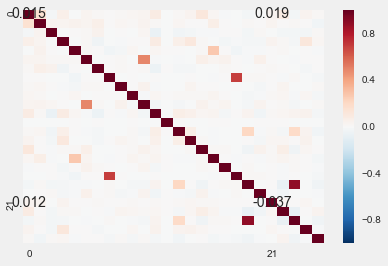

In [56]:
mat_correlation = np.corrcoef([plot_data[col_name[0]].reshape(-1,) 
                              ,plot_data[col_name[1]].reshape(-1,)  
                              ,plot_data[col_name[2]].reshape(-1,)
                               ,plot_data[col_name[3]].reshape(-1,) 
                               ,plot_data[col_name[4]].reshape(-1,) 
                               ,plot_data[col_name[5]].reshape(-1,) 
                               ,plot_data[col_name[6]].reshape(-1,) 
                               ,plot_data[col_name[7]].reshape(-1,) 
                               ,plot_data[col_name[8]].reshape(-1,) 
                               ,plot_data[col_name[9]].reshape(-1,) 
                               ,plot_data[col_name[10]].reshape(-1,)
                              ,plot_data[col_name[11]].reshape(-1,)  
                              ,plot_data[col_name[12]].reshape(-1,)
                               ,plot_data[col_name[13]].reshape(-1,) 
                               ,plot_data[col_name[14]].reshape(-1,) 
                               ,plot_data[col_name[15]].reshape(-1,) 
                               ,plot_data[col_name[16]].reshape(-1,) 
                               ,plot_data[col_name[17]].reshape(-1,) 
                               ,plot_data[col_name[18]].reshape(-1,) 
                               ,plot_data[col_name[19]].reshape(-1,) 
                               ,plot_data[col_name[20]].reshape(-1,)
                               ,plot_data[col_name[21]].reshape(-1,) 
                               ,plot_data[col_name[22]].reshape(-1,) 
                               ,plot_data[col_name[23]].reshape(-1,) 
                               ,plot_data[col_name[24]].reshape(-1,) 
                               ,plot_data[col_name[25]].reshape(-1,)])

print(mat_correlation)

sb.heatmap(mat_correlation, annot=True, xticklabels=21, yticklabels=21)

In [57]:
mat_correlation.shape

(26, 26)

In [58]:
col_name

array(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_REGISTRATION',
       'DAYS_EMPLOYED', 'REGION_POPULATION_RELATIVE', 'AMT_CREDIT',
       'DAYS_BIRTH', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_INCOME_TOTAL',
       'NAME_HOUSING_TYPE', 'AMT_ANNUITY', 'CNT_CHILDREN',
       'WEEKDAY_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'DAYS_ID_PUBLISH', 'NAME_EDUCATION_TYPE', 'HOUSETYPE_MODE',
       'OCCUPATION_TYPE', 'TARGET'], dtype=object)

In [59]:
mat_correlation_copy = mat_correlation[-1].copy()
mat_correlation_copy = np.abs(mat_correlation_copy)
mat_correlation_copy[mat_correlation_copy >=0.99] = 0
max_index = np.empty(0, dtype=int)
RANK = 3
for i in range(0, RANK):
    max_index = np.append(max_index, np.unravel_index(np.argmax(mat_correlation_copy), mat_correlation_copy.shape))
    value = mat_correlation_copy[int(max_index[i])]
    mat_correlation_copy[mat_correlation_copy == value] = 0      
    
top_ten = max_index

print("選んだ特徴量\n{}".format(col_name[top_ten]))

選んだ特徴量
['EMERGENCYSTATE_MODE' 'HOUSETYPE_MODE' 'EXT_SOURCE_2']


相関の強い特徴量が３つ存在 => 主系列分析で３つ次元を落とす

#### 【問題4】高い汎化性能のモデル
これまで学んだことを用いながら汎化性能の高いモデルを作成してください。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

Polynomial Featuresを使い特徴量を増やす

In [60]:

selected_feature_name = ['EXT_SOURCE_1',
                         'EXT_SOURCE_2',
                         'DAYS_REGISTRATION',
                         'DAYS_EMPLOYED',
                         'AMT_CREDIT',
                         'DAYS_BIRTH',
                         'AMT_INCOME_TOTAL',
                         'NAME_HOUSING_TYPE',
                         'AMT_ANNUITY',
                         'CNT_CHILDREN',
                         'ORGANIZATION_TYPE',
                         'OCCUPATION_TYPE']
col_name = copy.deepcopy(selected_feature_name)
col_name.append("TARGET")

In [61]:
# Make a new dataframe for polynomial features
poly_features = pd_application_train[col_name]
#poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(['TARGET'], axis=1)

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
#poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

/Users/naoki/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [62]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
#poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 455)


In [63]:
poly_transformer.get_feature_names(input_features = 
                                   col_name)

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'AMT_INCOME_TOTAL',
 'NAME_HOUSING_TYPE',
 'AMT_ANNUITY',
 'CNT_CHILDREN',
 'ORGANIZATION_TYPE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 DAYS_REGISTRATION',
 'EXT_SOURCE_1 DAYS_EMPLOYED',
 'EXT_SOURCE_1 AMT_CREDIT',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_1 AMT_INCOME_TOTAL',
 'EXT_SOURCE_1 NAME_HOUSING_TYPE',
 'EXT_SOURCE_1 AMT_ANNUITY',
 'EXT_SOURCE_1 CNT_CHILDREN',
 'EXT_SOURCE_1 ORGANIZATION_TYPE',
 'EXT_SOURCE_1 OCCUPATION_TYPE',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 DAYS_REGISTRATION',
 'EXT_SOURCE_2 DAYS_EMPLOYED',
 'EXT_SOURCE_2 AMT_CREDIT',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_2 AMT_INCOME_TOTAL',
 'EXT_SOURCE_2 NAME_HOUSING_TYPE',
 'EXT_SOURCE_2 AMT_ANNUITY',
 'EXT_SOURCE_2 CNT_CHILDREN',
 'EXT_SOURCE_2 ORGANIZATION_TYPE',
 'EXT_SOURCE_2 OCCUPATION_TYPE',
 'DAYS_REGISTRATION^2',
 'DAYS_REGISTRATION DAYS_EMPLOYED',
 'DAYS_R

In [64]:
from sklearn.preprocessing import MinMaxScaler
#元データに新しい特徴量を追加
# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))
poly_features = scaler.fit_transform(poly_features)
#poly_features.shape

#poly featureをpandas dataframeへ
poly_col_name = poly_transformer.get_feature_names(input_features = col_name)

pd_poly_features = pd.DataFrame(poly_features, columns=poly_col_name)
pd_poly_features.head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_REGISTRATION,DAYS_EMPLOYED,AMT_CREDIT,DAYS_BIRTH,AMT_INCOME_TOTAL,NAME_HOUSING_TYPE,AMT_ANNUITY,CNT_CHILDREN,ORGANIZATION_TYPE,OCCUPATION_TYPE,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 DAYS_REGISTRATION,EXT_SOURCE_1 DAYS_EMPLOYED,EXT_SOURCE_1 AMT_CREDIT,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_1 AMT_INCOME_TOTAL,EXT_SOURCE_1 NAME_HOUSING_TYPE,EXT_SOURCE_1 AMT_ANNUITY,EXT_SOURCE_1 CNT_CHILDREN,EXT_SOURCE_1 ORGANIZATION_TYPE,EXT_SOURCE_1 OCCUPATION_TYPE,EXT_SOURCE_2^2,EXT_SOURCE_2 DAYS_REGISTRATION,EXT_SOURCE_2 DAYS_EMPLOYED,EXT_SOURCE_2 AMT_CREDIT,EXT_SOURCE_2 DAYS_BIRTH,EXT_SOURCE_2 AMT_INCOME_TOTAL,EXT_SOURCE_2 NAME_HOUSING_TYPE,EXT_SOURCE_2 AMT_ANNUITY,EXT_SOURCE_2 CNT_CHILDREN,EXT_SOURCE_2 ORGANIZATION_TYPE,EXT_SOURCE_2 OCCUPATION_TYPE,DAYS_REGISTRATION^2,DAYS_REGISTRATION DAYS_EMPLOYED,DAYS_REGISTRATION AMT_CREDIT,DAYS_REGISTRATION DAYS_BIRTH,DAYS_REGISTRATION AMT_INCOME_TOTAL,DAYS_REGISTRATION NAME_HOUSING_TYPE,DAYS_REGISTRATION AMT_ANNUITY,DAYS_REGISTRATION CNT_CHILDREN,DAYS_REGISTRATION ORGANIZATION_TYPE,DAYS_REGISTRATION OCCUPATION_TYPE,DAYS_EMPLOYED^2,DAYS_EMPLOYED AMT_CREDIT,DAYS_EMPLOYED DAYS_BIRTH,DAYS_EMPLOYED AMT_INCOME_TOTAL,DAYS_EMPLOYED NAME_HOUSING_TYPE,DAYS_EMPLOYED AMT_ANNUITY,DAYS_EMPLOYED CNT_CHILDREN,DAYS_EMPLOYED ORGANIZATION_TYPE,DAYS_EMPLOYED OCCUPATION_TYPE,AMT_CREDIT^2,AMT_CREDIT DAYS_BIRTH,AMT_CREDIT AMT_INCOME_TOTAL,AMT_CREDIT NAME_HOUSING_TYPE,AMT_CREDIT AMT_ANNUITY,AMT_CREDIT CNT_CHILDREN,...,DAYS_BIRTH CNT_CHILDREN ORGANIZATION_TYPE,DAYS_BIRTH CNT_CHILDREN OCCUPATION_TYPE,DAYS_BIRTH ORGANIZATION_TYPE^2,DAYS_BIRTH ORGANIZATION_TYPE OCCUPATION_TYPE,DAYS_BIRTH OCCUPATION_TYPE^2,AMT_INCOME_TOTAL^3,AMT_INCOME_TOTAL^2 NAME_HOUSING_TYPE,AMT_INCOME_TOTAL^2 AMT_ANNUITY,AMT_INCOME_TOTAL^2 CNT_CHILDREN,AMT_INCOME_TOTAL^2 ORGANIZATION_TYPE,AMT_INCOME_TOTAL^2 OCCUPATION_TYPE,AMT_INCOME_TOTAL NAME_HOUSING_TYPE^2,AMT_INCOME_TOTAL NAME_HOUSING_TYPE AMT_ANNUITY,AMT_INCOME_TOTAL NAME_HOUSING_TYPE CNT_CHILDREN,AMT_INCOME_TOTAL NAME_HOUSING_TYPE ORGANIZATION_TYPE,AMT_INCOME_TOTAL NAME_HOUSING_TYPE OCCUPATION_TYPE,AMT_INCOME_TOTAL AMT_ANNUITY^2,AMT_INCOME_TOTAL AMT_ANNUITY CNT_CHILDREN,AMT_INCOME_TOTAL AMT_ANNUITY ORGANIZATION_TYPE,AMT_INCOME_TOTAL AMT_ANNUITY OCCUPATION_TYPE,AMT_INCOME_TOTAL CNT_CHILDREN^2,AMT_INCOME_TOTAL CNT_CHILDREN ORGANIZATION_TYPE,AMT_INCOME_TOTAL CNT_CHILDREN OCCUPATION_TYPE,AMT_INCOME_TOTAL ORGANIZATION_TYPE^2,AMT_INCOME_TOTAL ORGANIZATION_TYPE OCCUPATION_TYPE,AMT_INCOME_TOTAL OCCUPATION_TYPE^2,NAME_HOUSING_TYPE^3,NAME_HOUSING_TYPE^2 AMT_ANNUITY,NAME_HOUSING_TYPE^2 CNT_CHILDREN,NAME_HOUSING_TYPE^2 ORGANIZATION_TYPE,NAME_HOUSING_TYPE^2 OCCUPATION_TYPE,NAME_HOUSING_TYPE AMT_ANNUITY^2,NAME_HOUSING_TYPE AMT_ANNUITY CNT_CHILDREN,NAME_HOUSING_TYPE AMT_ANNUITY ORGANIZATION_TYPE,NAME_HOUSING_TYPE AMT_ANNUITY OCCUPATION_TYPE,NAME_HOUSING_TYPE CNT_CHILDREN^2,NAME_HOUSING_TYPE CNT_CHILDREN ORGANIZATION_TYPE,NAME_HOUSING_TYPE CNT_CHILDREN OCCUPATION_TYPE,NAME_HOUSING_TYPE ORGANIZATION_TYPE^2,NAME_HOUSING_TYPE ORGANIZATION_TYPE OCCUPATION_TYPE,NAME_HOUSING_TYPE OCCUPATION_TYPE^2,AMT_ANNUITY^3,AMT_ANNUITY^2 CNT_CHILDREN,AMT_ANNUITY^2 ORGANIZATION_TYPE,AMT_ANNUITY^2 OCCUPATION_TYPE,AMT_ANNUITY CNT_CHILDREN^2,AMT_ANNUITY CNT_CHILDREN ORGANIZATION_TYPE,AMT_ANNUITY CNT_CHILDREN OCCUPATION_TYPE,AMT_ANNUITY ORGANIZATION_TYPE^2,AMT_ANNUITY ORGANIZATION_TYPE OCCUPATION_TYPE,AMT_ANNUITY OCCUPATION_TYPE^2,CNT_CHILDREN^3,CNT_CHILDREN^2 ORGANIZATION_TYPE,CNT_CHILDREN^2 OCCUPATION_TYPE,CNT_CHILDREN ORGANIZATION_TYPE^2,CNT_CHILDREN ORGANIZATION_TYPE OCCUPATION_TYPE,CNT_CHILDREN OCCUPATION_TYPE^2,ORGANIZATION_TYPE^3,ORGANIZATION_TYPE^2 OCCUPATION_TYPE,ORGANIZATION_TYPE OCCUPATION_TYPE^2,OCCUPATION_TYPE^3
0,0.0,0.000009,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000073,0.0,0.000000,0.055556,0.000000e+00,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000059,0.00001,0.000009,0.055742,0.000000e+00,0.000008,0.000008,0.000007,0.000008,0.000008,0.0000

In [65]:
train_data_w_poly = pd.concat([pd_application_train, pd_poly_features], axis=1)

In [66]:
selected_feature_name_w_poly = selected_feature_name + poly_col_name
print(selected_feature_name_w_poly)

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE', 'AMT_ANNUITY', 'CNT_CHILDREN', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', '1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'DAYS_EMPLOYED', 'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE', 'AMT_ANNUITY', 'CNT_CHILDREN', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 DAYS_REGISTRATION', 'EXT_SOURCE_1 DAYS_EMPLOYED', 'EXT_SOURCE_1 AMT_CREDIT', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_1 AMT_INCOME_TOTAL', 'EXT_SOURCE_1 NAME_HOUSING_TYPE', 'EXT_SOURCE_1 AMT_ANNUITY', 'EXT_SOURCE_1 CNT_CHILDREN', 'EXT_SOURCE_1 ORGANIZATION_TYPE', 'EXT_SOURCE_1 OCCUPATION_TYPE', 'EXT_SOURCE_2^2', 'EXT_SOURCE_2 DAYS_REGISTRATION', 'EXT_SOURCE_2 DAYS_EMPLOYED', 'EXT_SOURCE_2 AMT_CREDIT', 'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_2 AMT_INCOME_TOTAL', 'EXT_SOURCE_2 NAME_HOUSING_TYPE', 'EXT_SOURCE_2 AM

In [67]:
#Pipelineを回す
clf = RandomForestClassifier(
    n_estimators=30, max_depth=120, random_state=100, criterion="entropy", bootstrap="True")

#pipelineパラメーター
POSITIVE_LABEL = 1

params_ext = {
         "normalization_on": True,
          "roc_plot_on": False,
          "cv_on": True,
          "cv_split": 3,
          "cv_random_state" : None,
          "cv_shuffle" : True,
          "grid_search_on" : False,
        }
#Grid search
param_grid = {
            "hyper_param":{
                "max_depth": [50, 120],
                "max_features": [3, 10],
                "min_samples_split": [3, 10],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"],
                "n_estimators" : [30, 50, 100],
                "random_state" : [10, 50, 100]
            },
            "grid_search_param":{
                    "grid_search_cv":2
            }
        }

#Run pipeline
pipeline2(
    clf, train_data_w_poly, "TARGET", selected_feature_name_w_poly, POSITIVE_LABEL, 
    params=params_ext, 
    params_grid=param_grid)

Run cross validation
Normalize feature data
AUC=0.52846
Auc :  0.5284569599182091
Normalize feature data
AUC=0.51012
Auc :  0.5101230924893104
Normalize feature data
AUC=0.51633
Auc :  0.516326946647503
AUC for cv (Ave of 3 cv split) : 0.5183023330183408


(array([[0.36666667, 0.63333333],
        [0.33333333, 0.66666667],
        [0.36666667, 0.63333333],
        ...,
        [0.16666667, 0.83333333],
        [0.03333333, 0.96666667],
        [0.3       , 0.7       ]]),
 array([0.        , 0.00277946, 0.01969789, 0.06344411, 0.14163142,
        0.24809668, 0.37389728, 0.50779456, 0.63577039, 0.75673716,
        0.85752266, 0.92241692, 0.96543807, 0.98670695, 0.99564955,
        0.99879154, 0.99975831, 1.        , 1.        , 1.        ]),
 array([0.        , 0.00595364, 0.0278049 , 0.07869211, 0.16273295,
        0.27439827, 0.40061341, 0.53116908, 0.6549221 , 0.7669907 ,
        0.85773868, 0.92395042, 0.9648406 , 0.98595959, 0.99519251,
        0.99866282, 0.9997453 , 0.99992571, 0.99998939, 1.        ]),
 0.516326946647503)